In [1]:
import glob
import cv2

In [2]:
import numpy as np

In [3]:
import tf_keras as keras
from tf_keras.datasets import mnist
from tf_keras.models import Sequential
from tf_keras.layers import Dense, Dropout, Flatten
from tf_keras.layers import Conv2D, MaxPooling2D
from tf_keras import backend as K

In [4]:
from tf_keras.preprocessing.image import ImageDataGenerator

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### Создаём аугментатор

In [7]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
)

### Выбираем размер изображений

In [8]:
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

### Загружаем набор данных

In [10]:
age_labels = []
gender_labels = []
images = []

for image_name in glob.glob('./UTKFace/*.jpg'):
    items = image_name.rsplit('/', 1)[1].rsplit('\\', 1)[1].split('_') 
    
    age = int(items[0])
    gender = int(items[1])
    
    age_labels.append(age)
    gender_labels.append(gender)
    
    image = cv2.imread(image_name)
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.resize(gray_image, (img_rows, img_cols), interpolation = cv2.INTER_CUBIC)    
    gray_image = gray_image.reshape((img_rows, img_cols, 1))
    
    images.append(gray_image)

age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)
images = np.array(images)

In [11]:
images = images / 255.0 # type: ignore

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, gender_labels, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(images, age_labels, test_size=0.3, random_state=42)

In [13]:
num_classes = np.unique(gender_labels).shape[0]

In [14]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Создаём модель

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(96, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(1, kernel_initializer='normal'))

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)
# model.compile(loss='mean_squared_error',
#               optimizer='rmsprop',
#               metrics=['mse', 'mae', 'mape'])

### Обучаем модель

In [17]:
datagen.fit(X_train)

In [20]:
batch_size = 128
epochs = 100

In [21]:
import tensorflow as tf

with tf.device('/GPU:0'):
    history_callback =  model.fit_generator(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_test, y_test),
        workers=4
    )

Epoch 1/100


C:\Users\roaoc\AppData\Local\Temp\ipykernel_7780\738339635.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_callback =  model.fit_generator(


90/90 [==============================] - 29s 325ms/step - loss: 0.5902 - accuracy: 0.6928 - val_loss: 0.5041 - val_accuracy: 0.7548
Epoch 2/100
90/90 [==============================] - 28s 311ms/step - loss: 0.5774 - accuracy: 0.7015 - val_loss: 0.5104 - val_accuracy: 0.7489
Epoch 3/100
90/90 [==============================] - 28s 308ms/step - loss: 0.5659 - accuracy: 0.7080 - val_loss: 0.4667 - val_accuracy: 0.7770
Epoch 4/100
90/90 [==============================] - 28s 309ms/step - loss: 0.5488 - accuracy: 0.7244 - val_loss: 0.4552 - val_accuracy: 0.7776
Epoch 5/100
90/90 [==============================] - 28s 308ms/step - loss: 0.5329 - accuracy: 0.7357 - val_loss: 0.4293 - val_accuracy: 0.7992
Epoch 6/100
90/90 [==============================] - 28s 308ms/step - loss: 0.5163 - accuracy: 0.7417 - val_loss: 0.4144 - val_accuracy: 0.8065
Epoch 7/100
90/90 [==============================] - 28s 307ms/step - loss: 0.5081 - accuracy: 0.7558 - val_loss: 0.4070 - val_accuracy: 0.8146
Epoc

In [22]:
loss_history = history_callback.history["loss"]

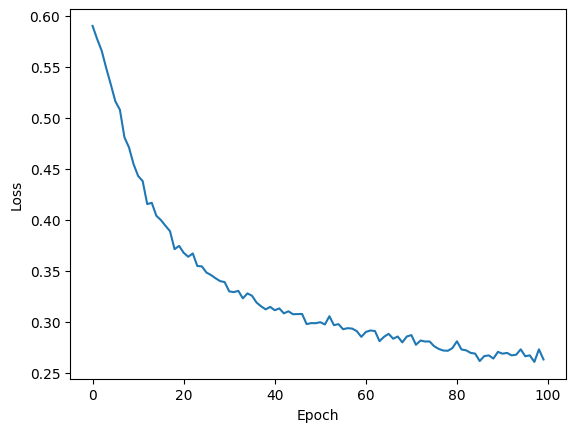

In [23]:
plt.plot(loss_history)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Смотрим на предсказания

1/1 [==============================] - 0s 18ms/step
[0.0036843 0.9963158]
[0. 1.]


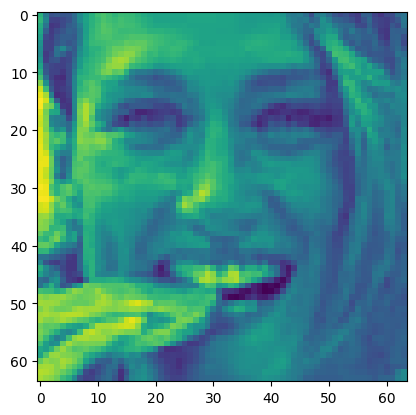

In [36]:
img_idx = 1000
p_age = model.predict(np.array([X_test[img_idx]]))
print(p_age[0])
print(y_test[img_idx])
plt.imshow(X_test[img_idx].reshape(img_cols, img_rows))
plt.show()

### Сохраняем модель

In [37]:
model_json = model.to_json()
with open("gender_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gender_model.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
from tf_keras.models import model_from_json

In [39]:
keras.__version__

'2.18.0'

### Загружаем модель

In [46]:
# load json and create model
json_file = open('gender_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [47]:
# load weights into new model
loaded_model.load_weights("gender_model.h5") # type: ignore
print("Loaded model from disk")

Loaded model from disk


1/1 [==============================] - 0s 57ms/step
[0.59041077 0.40958926]
[0. 1.]


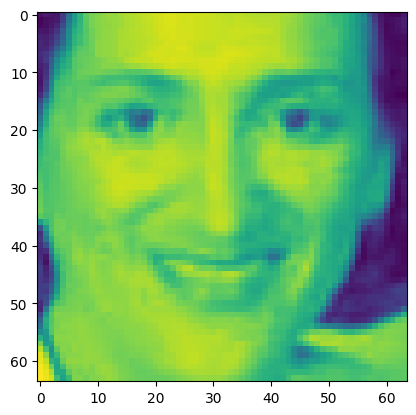

In [48]:
img_idx = 1090
p_age = loaded_model.predict(np.array([X_test[img_idx]])) # type: ignore
print(p_age[0])
print(y_test[img_idx])
plt.imshow(X_test[img_idx].reshape(img_cols, img_rows))
plt.show()